In [ ]:
# default_exp funcs.output_trafo

In [ ]:
%load_ext autoreload
%autoreload 2
%aimport -decode_fish.engine.place_psfs

# Transformations of sampled data and model output into emitter dataframes

In [ ]:
#export
from decode_fish.imports import *
from decode_fish.funcs.utils import *
import torch.nn.functional as F

In [ ]:
# export
def sample_to_df(locs, x_os, y_os, z_os, ints, codes, px_size_zyx=[100,100,100]):
    
    x = locs[-1] + x_os + 0.5 
    y = locs[-2] + y_os + 0.5 
    z = locs[-3] + z_os + 0.5 
    
    n_gt = len(x)
    channels = ints.shape[1]
    
    frame_idx = locs[0]
    
    df = DF({'loc_idx': torch.arange(n_gt),
             'frame_idx': frame_idx.cpu(),
             'x': x.cpu()*px_size_zyx[2],
             'y': y.cpu()*px_size_zyx[1], 
             'z': z.cpu()*px_size_zyx[0]}) 
    
    for i in range(channels):
        df[f'int_{i}'] = ints[:,i].cpu()
        
    df['code_inds'] = codes
    df['ints'] = ints.sum(-1).cpu()

    return df

# def df_to_micro(df, px_size_zyx=[100,100,100]):
    
#     locs = tuple([torch.tensor(df['frame_idx'],dtype=torch.int64).cuda(),
#                  torch.zeros(len(df),dtype=torch.int64).cuda(),
#                  torch.tensor((df['z']/px_size_zyx[0] + 0.5),dtype=torch.int64).cuda(),
#                  torch.tensor((df['y']/px_size_zyx[1] + 0.5),dtype=torch.int64).cuda(),
#                  torch.tensor((df['x']/px_size_zyx[2] + 0.5),dtype=torch.int64).cuda()])
#     z = (torch.tensor(df['z'],dtype=torch.float32).cuda()-locs[2]*px_size_zyx[0])/px_size_zyx[0] - 0.5
#     y = (torch.tensor(df['y'],dtype=torch.float32).cuda()-locs[3]*px_size_zyx[1])/px_size_zyx[1] - 0.5
#     x = (torch.tensor(df['x'],dtype=torch.float32).cuda()-locs[4]*px_size_zyx[2])/px_size_zyx[2] - 0.5
#     ints = torch.tensor(df['int']).cuda()

#     return locs, x, y, z, ints

In [ ]:
from decode_fish.funcs.exp_specific import get_starfish_codebook
code_ref, targets = get_starfish_codebook()

In [ ]:
from decode_fish.engine.point_process import PointProcessUniform
point_process = PointProcessUniform(local_rate = torch.ones([7,1,48,48]).cuda()*.3, int_conc=3, int_rate=1, int_loc=1, sim_iters=1, channels=16, n_bits=4, codebook=torch.tensor(code_ref, dtype=torch.bool), int_option=1)
locs_3d, x_os_3d, y_os_3d, z_os_3d, ints_3d, output_shape, codes = point_process.sample(from_code_book=True, phasing=False)

/groups/turaga/home/speisera/anaconda3/envs/decode_fish_dev2/lib/python3.8/site-packages/torch/cuda/__init__.py:122: UserWarning: 
    Found GPU2 NVS 510 which is of cuda capability 3.0.
    PyTorch no longer supports this GPU because it is too old.
    The minimum cuda capability supported by this library is 3.7.
    
  warnings.warn(old_gpu_warn % (d, name, major, minor, min_arch // 10, min_arch % 10))


In [ ]:
sample_df = sample_to_df(locs_3d, x_os_3d, y_os_3d, z_os_3d, ints_3d, codes)
sample_df

,loc_idx,frame_idx,x,y,z,int_0,int_1,int_2,int_3,int_4,...,int_8,int_9,int_10,int_11,int_12,int_13,int_14,int_15,code_inds,ints
0,0,0,69.408348,10.274011,40.166759,0.000000,0.000000,0.000000,0.000000,0.000000,...,2.645418,1.721832,0.000000,0.000000,0.000000,0.0,0.000000,5.19887,11,11.335569
1,1,0,194.581421,48.548389,56.380062,2.102284,0.000000,0.000000,0.000000,9.110406,...,0.000000,0.000000,0.000000,0.000000,2.466749,0.0,0.000000,0.00000,99,16.707592
2,2,0,503.604950,83.724770,24.907244,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,3.963071,0.000000,0.0,3.380349,2.58474,89,12.322065
3,3,0,668.131897,16.448217,65.646347,0.000000,0.000000,2.395624,5.492817,0.000000,...,0.000000,7.676136,0.000000,2.544351,0.000000,0.0,0.000000,0.00000,36,18.108929
4,4,0,797.285278,54.767406,78.664536,2.986576,6.511186,5.848161,0.000000,0.000000,...,0.000000,0.000000,0.000000,3.596924,0.000000,0.0,0.000000,0.00000,1,18.942846
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4829,4829,6,3756.114990,4732.571289,44.550961,4.178919,0.000000,0.000000,3.225204,3.130101,...,0.000000,0.000000,1.841708,0.000000,0.000000,0.0,0.000000,0.00000,129,12.375932
4830,4830,6,3858.953125,4745.737305,11.505985,0.000000,3.302485,0.000000,0.000000,7.230642,...,0.000000,3.076677,2.272797,0.000000,0.000000,0.0,0.000000,0.00000,3,15.882601
4831,4831,6,4597.104004,4720.035645,29.927708,0.000000,4.345507,0.000000,2.524360,0.000000,...,0.000000,0.000000,0.000000,4.444644,0.000000,0.0,0.000000,0.00000,33,16.577000
4832,4832,6,4666.370117,4786.185547,34.219795,4.096021,3.045037,0.000000,3.625421,0.000000,...,0.000000,3.606956,0.000000,0.000000,0.000000,0.0,0.000000,0.00000,28,14.373436


In [ ]:
#export
class SIPostProcess(torch.nn.Module):
    
    def __init__(self, m1_threshold:float = 0.03, m2_threshold:float = 0.3, samp_threshold=0.1, px_size_zyx=[100,100,100], diag=0):
        
        super().__init__()
        self.m1_threshold = m1_threshold
        self.m2_threshold = m2_threshold
        self.samp_threshold = samp_threshold
        self.diag = diag
        self.px_size_zyx = px_size_zyx
        self.codebook = False
        
        if not diag:
            d1 = 0; d2 = 0
        else:
            d1 = 1/np.sqrt(2); d2 = 1/np.sqrt(3)
#             d1 = 1; d2 = 1
        self.filt = torch.FloatTensor([[[d2,d1,d2],[d1,1,d1],[d2,d1,d2]],
                                       [[d1, 1,d1],[1, 1, 1],[d1, 1,d1]],
                                       [[d2,d1,d2],[d1,1,d1],[d2,d1,d2]]])[None,None]
        
    def forward(self, logits):

        device = logits.device
        p = torch.sigmoid(logits)

        with torch.no_grad():

            p_copy = p + 0

            # probability values > threshold are regarded as possible locations
            p_clip = torch.where(p>self.m1_threshold,p,torch.zeros_like(p))

            # localize maximum values within a 3x3 patch
            pool = F.max_pool3d(p_clip,3,1,padding=1)
            max_mask1 = torch.eq(p, pool).float()

            # Add probability values from the 4 adjacent pixels
            conv = F.conv3d(p, self.filt.to(device) ,padding=1)
            p_ps1 = (max_mask1 * conv)

            # In order do be able to identify two fluorophores in adjacent pixels we look for probablity values > 0.5 that are not part of the first mask

            p_copy *= (1-max_mask1)
            p_clip = torch.where(p_copy>self.m2_threshold, p_copy,torch.zeros_like(p_copy))
            max_mask2 = torch.where(p_copy>self.m2_threshold, torch.ones_like(p_copy),torch.zeros_like(p_copy))
            p_ps2 = max_mask2*conv

            # This is our final clustered probablity which we then threshold (normally > 0.7) to get our final discrete locations 
            p_ps = p_ps1 + p_ps2        

            return p_ps
        
    def get_si_resdict(self, res_dict, p_si=None):
        
        if p_si is None:
            p_si = self.forward(res_dict['logits'])
            
        res_dict['Probs_si'] = p_si
        res_dict['Samples_si'] = torch.where(res_dict['Probs_si'] > self.samp_threshold, torch.ones_like(res_dict['Probs_si']), torch.zeros_like(res_dict['Probs_si']))
        
        return res_dict
        
    def get_df(self, res_dict, p_si=None, softmax=False):
        
        res_dict = self.get_si_resdict(res_dict, p_si)
        
        res_dict = {k:v.cpu() for (k,v) in res_dict.items()}
        locations = res_dict['Samples_si'].nonzero(as_tuple=True)
        ch0_locs = locations[0], locations[1]*0, locations[2] ,locations[3], locations[4]

        pos_x, pos_y, pos_z = locations[-1] ,locations[-2], locations[-3]
        
        x = pos_x + res_dict['xyzi_mu'][:,[0]][ch0_locs] + 0.5 
        y = pos_y + res_dict['xyzi_mu'][:,[1]][ch0_locs] + 0.5 
        z = pos_z + res_dict['xyzi_mu'][:,[2]][ch0_locs] + 0.5

        loc_idx = torch.arange(len(x))
        frame_idx = locations[0]

        df = DF({'loc_idx': loc_idx,
                 'frame_idx': frame_idx,
                 'code_inds': locations[1],
                 'x': x*self.px_size_zyx[2],
                 'y': y*self.px_size_zyx[1], 
                 'z': z*self.px_size_zyx[0], 
                 'prob': res_dict['Probs_si'][locations], 
#                  'int': res_dict['xyzi_mu'][:,[3]][ch0_locs], 
#                  'int_sig': res_dict['xyzi_sigma'][:,[3]][ch0_locs], 
                 'x_sig': res_dict['xyzi_sigma'][:,[0]][ch0_locs]*self.px_size_zyx[0], 
                 'y_sig': res_dict['xyzi_sigma'][:,[1]][ch0_locs]*self.px_size_zyx[1], 
                 'z_sig': res_dict['xyzi_sigma'][:,[2]][ch0_locs]*self.px_size_zyx[2],
                 'comb_sig': torch.sqrt(res_dict['xyzi_sigma'][:,[0]][ch0_locs]**2
                                       +res_dict['xyzi_sigma'][:,[1]][ch0_locs]**2
                                       +res_dict['xyzi_sigma'][:,[2]][ch0_locs]**2)})
        
        for i in range(res_dict['xyzi_mu'].shape[1]-3):
            df[f'int_{i}'] = res_dict['xyzi_mu'][:,[3+i]][ch0_locs]
            df[f'int_sig_{i}'] = res_dict['xyzi_sigma'][:,[3+i]][ch0_locs]
            
        return df
        
    def get_micro_inp(self, res_dict, p_si=None):

        channels = self.codebook.shape[1]
        n_bits = (1.*self.codebook.sum(1)).mean()
        res_dict = self.get_si_resdict(res_dict, p_si)
        locations = res_dict['Samples_si'].nonzero(as_tuple=True)
        
        n_int = res_dict['xyzi_mu'].shape[1] - 3

        xyzi_ix = [locations[0],locations[2],locations[3], locations[4]]
        x_os_3d = res_dict['xyzi_mu'][:,0][xyzi_ix]
        y_os_3d = res_dict['xyzi_mu'][:,1][xyzi_ix]
        z_os_3d = res_dict['xyzi_mu'][:,2][xyzi_ix]
        
        if n_int == 1:
            ints_3d = res_dict['xyzi_mu'][:,3][xyzi_ix]
            ints_3d = ints_3d/n_bits
            ints_ret = ints_3d[:,None].repeat_interleave(channels, 1)
            ch_bin = self.codebook.to(ints_ret.device)[locations[1]]
            ints_ret = ints_ret*ch_bin
        
        if n_int == n_bits:
            code_inds = self.codebook.nonzero(as_tuple=True)[1].reshape([self.codebook.shape[0], -1])
            ints_3d = res_dict['xyzi_mu'][:,3:][locations[0],:,locations[2],locations[3], locations[4]]
            ints_ret = torch.zeros(ints_3d.shape[0], channels).to(ints_3d.device)
            ints_ret.scatter_(index=code_inds.to(ints_ret.device)[locations[1]], dim=1, src=ints_3d)
            
        if n_int == channels:
            ints_ret = res_dict['xyzi_mu'][:,3:][locations[0],:,locations[2],locations[3], locations[4]]
            ints_ret *= self.codebook.to(ints_ret.device)[locations[1]].ne(0)
        
        output_shape  = res_dict['Samples_si'].shape
        output_shape  = torch.Size([output_shape[0],channels,output_shape[2],output_shape[3],output_shape[4]])

        return xyzi_ix, x_os_3d, y_os_3d, z_os_3d, ints_ret, output_shape
# p_col = []

In [ ]:
#export
class ISIPostProcess(SIPostProcess):
    
    def __init__(self, m1_threshold:float = 0.1, samp_threshold=0.1, px_size_zyx=[100,100,100], diag=False):
        
        super().__init__(m1_threshold = m1_threshold, samp_threshold=samp_threshold, px_size_zyx=px_size_zyx, diag=diag)
        self.m2_threshold = None
        
    def forward(self, logits):

        device = logits.device
        p = torch.sigmoid(logits)
        
        batch_size = p.shape[0]
        n_codes = p.shape[1]
        
        p = p.reshape(batch_size*n_codes,1,*p.shape[-3:])
        
        with torch.no_grad():
            
            p_SI = 0
            tot_mask = torch.ones_like(p)
            max_mask = torch.ones_like(p)
            
            while max_mask.sum():
                
                # voxels with probability values > threshold,
                # and which where not previously counted as locations, are canditates
                p_cand = torch.where(p>self.m1_threshold, p, torch.zeros_like(p)) * tot_mask

                # localize maximum (nonzero) values within a 3x3x3 volume
                p_cand = F.max_pool3d(p_cand,3,1,padding=1)
                max_mask = torch.eq(p, p_cand).float()
                max_mask[p==0] = 0
                
                # Add up probability values from the adjacent pixels
                conv = F.conv3d(p, self.filt.to(device), padding=1)
                p_sum = max_mask * conv
                
                # Add the integrated probabilities to the return tensor. 
                p_SI += torch.clamp_max(p_sum, 1) 
                # Voxels that where added can not be added again
                tot_mask *= (torch.ones_like(max_mask) - max_mask)
                
                # The probability mass that contributed to p_sum is removed.
                p_fac = 1/p_sum
                p_fac[torch.isinf(p_fac)] = 0
                p_fac = torch.clamp_max(p_fac, 1) 
                p_proc = F.conv3d(p_fac, self.filt.to(device),padding=1)*p

                p = p - p_proc
                torch.clamp_min_(p, 0)
            
            return p_SI.reshape(batch_size,n_codes,*p.shape[-3:])

In [ ]:
from decode_fish.funcs.evaluation import *

post_proc1 = SIPostProcess(m1_threshold=0.03, m2_threshold=0.25, samp_threshold=0.6, px_size_zyx=[100,100,100], diag=True)
post_proc2 = ISIPostProcess(m1_threshold=0.03, samp_threshold=0.5, px_size_zyx=[100,100,100], diag=True)

# matching(px_to_nm(gt_df),  post_proc1.forward(model_out, ret='df'), tolerance=500, print_res=True)
# _=matching(px_to_nm(gt_df),  post_proc2.forward(model_out, ret='df'), tolerance=500, print_res=True)

In [ ]:
model_out = torch.load('../data/model_batch_output_class.pt')

In [ ]:
from decode_fish.funcs.exp_specific import get_starfish_codebook
codebook, targets = get_starfish_codebook()

In [ ]:
post_proc2 = ISIPostProcess(m1_threshold=0.03, samp_threshold=0.5, px_size_zyx=[100,100,100], diag=True)
post_proc2.codebook = torch.tensor(codebook)

In [ ]:
tra = post_proc2.get_micro_inp(model_out)
ints = tra[-2]

In [ ]:
ints.shape

torch.Size([1589, 16])

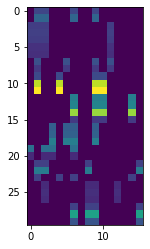

In [ ]:
plt.imshow(cpu(ints[:30]))

In [ ]:
post_proc2.get_df(model_out)

,loc_idx,frame_idx,code_inds,x,y,z,prob,x_sig,y_sig,z_sig,comb_sig,int_0,int_sig_0
0,0,0,0,9969.679688,5539.490234,50.0,1.000000,6.472965,6.863564,100.0,1.004441,4.360867,0.161154
1,1,0,0,5426.773438,9837.857422,50.0,0.999985,4.044147,4.181149,100.0,1.001691,6.776411,0.155932
2,2,0,1,10535.931641,1685.684814,50.0,1.000000,8.024311,8.992360,100.0,1.007236,3.783238,0.205821
3,3,0,1,10535.046875,1692.849976,50.0,0.624437,8.388150,9.016668,100.0,1.007555,4.017369,0.203333
4,4,0,1,6632.651367,3835.316895,50.0,1.000000,9.403131,9.706549,100.0,1.009090,3.856926,0.211836
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1584,1584,4,136,6737.703125,9106.716797,50.0,1.000000,6.765403,5.649927,100.0,1.003877,4.813341,0.172729
1585,1585,4,137,9255.159180,4070.848145,50.0,1.000000,11.793556,10.889218,100.0,1.012801,2.470911,0.157625
1586,1586,4,137,9098.880859,9725.834961,50.0,1.000000,5.979847,7.186817,100.0,1.004361,5.093824,0.195249
1587,1587,4,138,30.406862,17.821413,50.0,0.672839,29.970043,27.259970,100.0,1.078949,2.169087,0.231742


In [ ]:
!nbdev_build_lib

Converted 00_models.ipynb.
Converted 01_psf.ipynb.
Converted 02_microscope.ipynb.
Converted 02b_place_psfs.ipynb.
Converted 03_noise.ipynb.
Converted 04_pointsource.ipynb.
Converted 05_gmm_loss.ipynb.
Converted 06_plotting.ipynb.
Converted 07_file_io.ipynb.
Converted 08_dataset.ipynb.
Converted 09_output_trafo.ipynb.
Converted 10_evaluation.ipynb.
Converted 11_emitter_io.ipynb.
Converted 12_utils.ipynb.
Converted 13_train.ipynb.
Converted 15_fit_psf.ipynb.
Converted 16_visualization.ipynb.
Converted 17_eval_routines.ipynb.
Converted 18_predict_funcs.ipynb.
Converted 19_MERFISH_routines.ipynb.
Converted 20_MERFISH_visualization.ipynb.
Converted 22_MERFISH_codenet.ipynb.
Converted 23_MERFISH_comparison.ipynb.
Converted 24_exp_specific.ipynb.
Converted index.ipynb.
